[Open in Colab](https://colab.research.google.com/github/mizu-pumpkin/TFG2021/blob/main/sign_mnist/classifier_v4_resnet9.ipynb)

# Imports

In [1]:
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as T

import matplotlib
import matplotlib.pyplot as plt

# indicates to Jupyter that we want to plot the graphs within the notebook
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Define the model and evaluating functions

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [4]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=False)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [5]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [6]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

# Utilities for moving out data & labels to the GPU, if one is available.

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

# Training an image classifier for ASL alphabet

## Load sign-MNIST datasets and apply data augmentation

In [8]:
transforms = torch.nn.Sequential(
    T.RandomCrop(28, padding=4, padding_mode='reflect'),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10)
    )

# Define Dataset class
class SignMnistDataset(Dataset):
    """Sign MNIST dataset."""

    def __init__(self, csv_file, train=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            train (boolean): True when loading the train dataset.
        """
        self.raw_data = pd.read_csv(csv_file)
        self.train = train

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.raw_data.iloc[idx, 0]
        label = torch.tensor(label).type(torch.LongTensor)
        
        image = self.raw_data.iloc[idx, 1:].to_numpy()
        image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.reshape(image, (1, 28, 28))
        # Apply transforms for data augmentation in train dataset
        if self.train == True:
          image = transforms(image)
        
        return image, label

# Load train dataframe
dataset = SignMnistDataset('./dataset/sign_mnist_train.csv', train=True)
dataset.raw_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,194,193,193,194,194,195,195,196,194,195,196,196,197,196,197,197,196,195,195,189,190,192,192,193,194,195,196,196,196,193,...,115,92,132,173,118,84,53,135,253,213,219,208,82,82,84,85,85,87,84,87,78,113,216,189,172,175,155,131,116,93,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,167,169,169,169,169,169,169,169,169,169,167,167,167,166,165,164,164,163,162,153,156,159,160,162,163,164,165,167,169,172,...,199,200,199,199,198,199,198,197,196,195,195,194,66,67,65,62,61,41,32,37,33,30,28,38,187,202,199,199,199,199,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,173,173,172,171,171,171,170,169,168,166,166,165,165,163,162,161,160,158,156,178,178,177,176,177,177,177,176,176,176,175,...,110,85,90,166,205,207,205,203,202,201,200,198,217,217,217,218,218,211,203,200,189,171,157,145,136,129,128,125,101,77,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,190,191,193,192,191,191,191,191,190,190,189,187,186,184,183,182,181,179,177,179,182,185,187,189,190,192,192,192,192,194,...,190,173,140,80,28,60,70,61,61,78,100,86,136,135,135,135,132,132,136,136,137,144,103,120,197,200,195,196,170,149,119,56,27,58,102,79,47,64,87,93


Train dataset


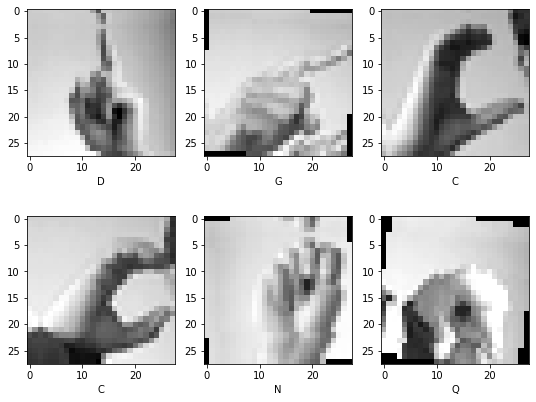

In [9]:
def int_to_char(num):
    return chr(num+65)

def plot_dataset(dataset):
    plt.figure(figsize=(9,7))
    for i in range(6):
        plt.subplot(2,3,i+1)
        image, label = dataset[i]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.xlabel(int_to_char(label.item()))
    plt.show()

print('Train dataset')
plot_dataset(dataset)

In [10]:
# Load test dataframe
test_ds = SignMnistDataset('./dataset/sign_mnist_test.csv')
test_ds.raw_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,133,143,148,156,160,162,164,168,171,173,175,178,179,181,182,184,185,185,186,137,116,111,101,110,92,66,108,124,132,155,...,147,132,115,112,117,118,112,153,189,178,173,166,140,121,157,125,93,99,100,101,104,100,118,167,154,141,136,139,135,125,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,176,176,176,178,176,176,178,177,176,178,178,177,176,176,176,174,174,173,173,159,163,164,166,168,169,173,175,177,178,177,...,90,78,191,215,212,214,212,209,209,208,208,207,189,192,196,199,191,208,230,201,197,185,184,187,169,136,131,107,69,127,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,192,193,192,191,192,191,191,192,189,189,189,188,188,188,187,186,185,184,183,193,193,193,193,193,193,194,194,193,195,195,...,215,215,215,214,213,213,212,212,210,209,208,207,215,215,207,207,208,207,203,196,170,99,92,92,89,155,213,216,216,216,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,229,234,233,233,237,237,237,240,241,238,240,240,242,243,241,239,239,239,239,206,209,212,215,218,220,223,226,227,229,236,...,168,173,128,127,255,255,255,255,159,99,80,77,255,255,255,255,255,255,231,255,255,255,255,255,249,231,188,164,169,176,112,169,255,255,237,113,91,67,70,63


Test dataset


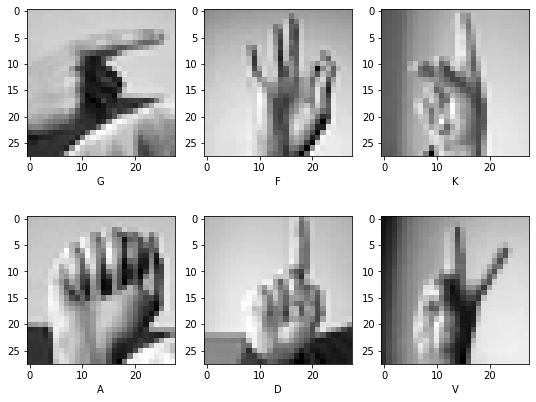

In [11]:
print('Test dataset')
plot_dataset(test_ds)

In [12]:
# Create training validation
val_size = int(len(dataset) * 0.15)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(23337, 4118)

In [13]:
# Create data loaders to load the data in batches
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# Move data loaders to the appropriate device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Train the network

In [22]:
# Training the model
model = ResNet9(1,26)
to_device(model, device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [23]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.04219585657119751, 'val_loss': 8.082952499389648}]

In [24]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.2969, val_acc: 0.5170
Epoch [1], val_loss: 0.7510, val_acc: 0.7852
Epoch [2], val_loss: 0.6075, val_acc: 0.8467
Epoch [3], val_loss: 0.0543, val_acc: 0.9832
Epoch [4], val_loss: 0.0144, val_acc: 0.9956
Epoch [5], val_loss: 0.0016, val_acc: 0.9995
Epoch [6], val_loss: 0.0012, val_acc: 0.9995
Epoch [7], val_loss: 0.0005, val_acc: 1.0000


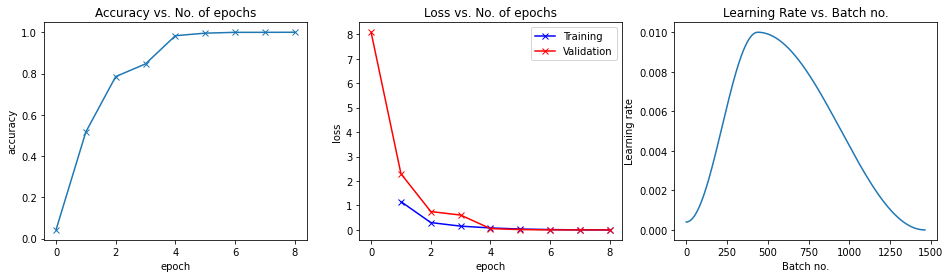

In [25]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plot_accuracies(history)
plt.subplot(1,3,2)
plot_losses(history)
plt.subplot(1,3,3)
plot_lrs(history)
plt.show()

In [29]:
torch.save(model.state_dict(), './models/classifier_v3.pth')

## Test

In [27]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 1.0, 'val_loss': 0.0001660051930230111}

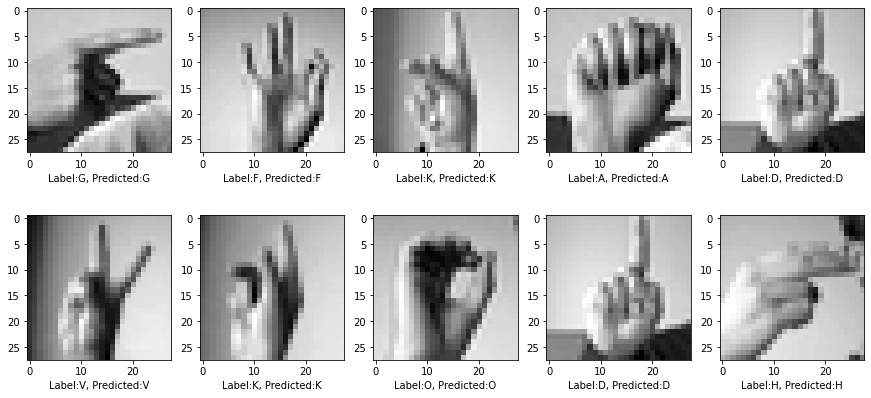

In [28]:
# Show prediction for single images
def predict_image(img, model):
    img = to_device(img, device)
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

def plot_prediction(dataset):
    plt.figure(figsize=(15,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image, label = dataset[i]
        plt.imshow(image[0], cmap='gray')
        lbl = 'Label:'+int_to_char(label.item())+', Predicted:'+int_to_char(predict_image(image, model))
        plt.xlabel(lbl)
    plt.show()

plot_prediction(test_ds)